**Goal of this exercise is to understand hypothesis testing using linear regression and how I can use this p-value to make real world decisions using linear regression.**

1. [Simple Linear Regression](#slr)
2. [Multi-linear regression](#mlr)


# 1. Simple Linear Regression
<a id='slr'></a>

### Data:
The following data is from an online rummy platform. Each row signifies one user's data for a few days on the platform. In this case, the independent variable is the deposit made by a player. The dependent variable is the commission given by the user to the platform (commission is called rake)

The goal is to prove that there is a positive relation between purchase and rake, and if possible estimate the unit increase in rake due to the purchase

**Hypothesis:** 
    
*Null Hypothesis (H0): As the purchase value of the user increases, the rake given by them remains unchanged*

*Alternative Hypothesis (H1): Higher the purchase value, higher the rake given by the user*

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t

df= pd.read_csv('./Datasets/sample_rake_purchase_data.csv')

In [2]:
df.head()

,user_identifier,total_purchase,total_rake
0,10097,100,88.00
1,10972,100,31.39
2,83634,100,57.00
3,90513,25,0.00
4,107849,25,4.08


In [3]:
df.total_rake.describe()

count     7124.000000
mean        50.155653
std        262.048275
min          0.000000
25%          1.167500
50%          7.800000
75%         22.037500
max      10818.220000
Name: total_rake, dtype: float64

In [4]:
print('mean=%.3f stdv=%.3f' % (np.mean(df['total_purchase']), np.std(df['total_purchase'])))

mean=162.808 stdv=1048.627


### Outlier removal: 
1. Interquartile range 
2. Z-score thresholding

In [5]:
# calculate interquartile range
q25, q75 = np.percentile(df['total_rake'], 25), np.percentile(df['total_rake'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

df_upd= df.query('@lower<total_rake<=@upper')

In [6]:
z_scores = stats.zscore(df_upd['total_purchase'])

# All values that are 2.5 standard deviations away from the mean will be removed
outliers = np.abs(z_scores) > 2.5
df_upd=df_upd[~outliers]

In [7]:
df_upd.total_rake.describe()

count    6170.000000
mean        9.563916
std        11.573986
min         0.000000
25%         0.460000
50%         5.500000
75%        13.355000
max        53.330000
Name: total_rake, dtype: float64

In [8]:
scaler= StandardScaler()
X= df_upd['total_purchase'].values.reshape(-1,1)
y= df_upd['total_rake'].values.reshape(-1,1)

In [9]:
X_scaled=X

In [10]:
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.2,shuffle=True)
model= LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [11]:

y_pred= model.predict(X_test)
print(mean_squared_error(y_pred=y_pred, y_true=y_test))
print(mean_absolute_error(y_pred=y_pred, y_true=y_test))

111.56540193208393
7.409529264814386


### Validating Assumptions of Linear Regression
1. Linearity
2. Independence
3. Normality
4. Homoscedasticity

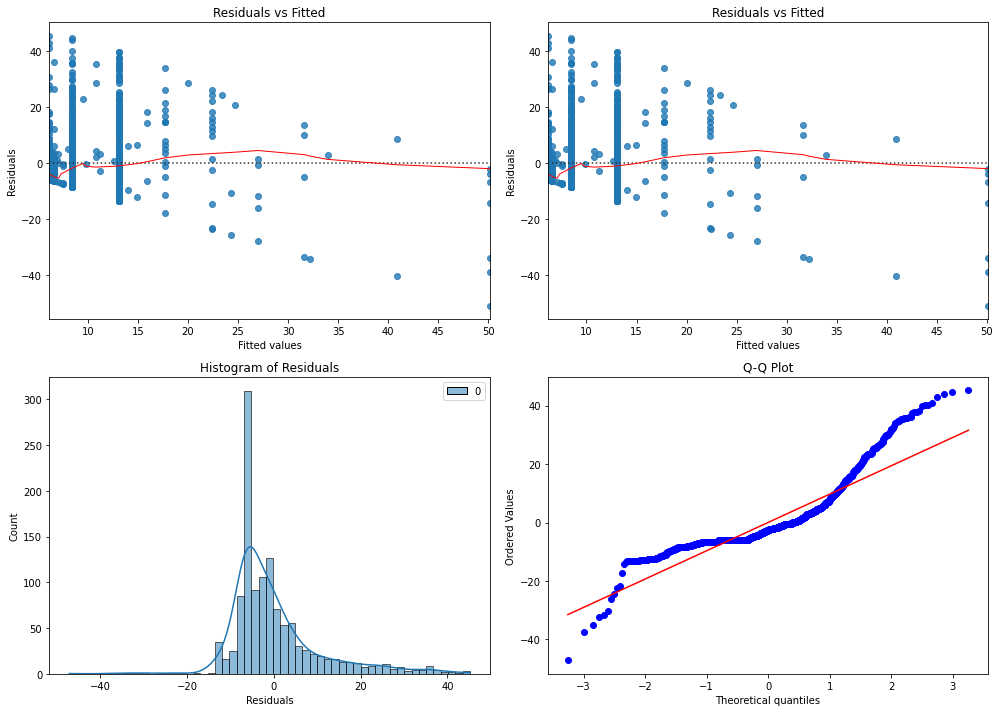

In [12]:
X = X_test
y = y_test
y_pred= model.predict(X_test)
residuals = y - y_pred


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot for Linearity: Residuals vs Fitted values
sns.residplot(x=y_pred.reshape(-1), y=residuals.reshape(-1), lowess=True, ax=axs[0, 0], line_kws={'color': 'red', 'lw': 1})
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

# Plot for Homoscedasticity: Residuals vs Fitted values
sns.residplot(x=y_pred.reshape(-1), y=residuals.reshape(-1), lowess=True, ax=axs[0, 1], line_kws={'color': 'red', 'lw': 1})
axs[0, 1].set_title('Residuals vs Fitted')
axs[0, 1].set_xlabel('Fitted values')
axs[0, 1].set_ylabel('Residuals')

# Plot for Normality: Histogram
sns.histplot(residuals, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Histogram of Residuals')
axs[1, 0].set_xlabel('Residuals')

# Plot for Normality: Q-Q Plot
stats.probplot(residuals.reshape(-1), dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()


### Finding out required coefficients for 2-tailed T-test

In [13]:
data_len= len(X_test)
residual=np.subtract(y_pred,y_test)

RSS= np.sum(residual**2)
standard_error= (RSS/(data_len-2))**0.5

X_mean=np.mean(X_test)
sum_squared_diff = np.sum((X_test - X_mean) ** 2)

se_b0 = standard_error * np.sqrt((1 / data_len) + (X_mean ** 2) / sum_squared_diff)
se_b1 = standard_error * np.sqrt(1 / sum_squared_diff)

t_b0= model.intercept_[0]/se_b0
t_b1= model.coef_[0]/se_b1

In [14]:

# Calculate two-tailed p-values
degrees_of_freedom=data_len-2
p_value_b0 = 2 * (1 - t.cdf(np.abs(t_b0), df=degrees_of_freedom))
p_value_b1 = 2 * (1 - t.cdf(np.abs(t_b1), df=degrees_of_freedom))

print(f'P-value for b0: {p_value_b0}')
print(f'P-value for b0: {p_value_b1}')

P-value for b0: 2.220446049250313e-16
P-value for b0: [0.]


In [15]:
# Define the alpha level for a 95% confidence interval
alpha = 0.05
model_intercept= model.intercept_[0]
model_coef= model.coef_[0][0]
# Find the t-value for the 95% confidence interval and the given degrees of freedom
t_critical = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Calculate the margin of error
margin_of_error_b0 = t_critical * se_b0
margin_of_error_b1 = t_critical * se_b1

# Calculate the confidence intervals
ci_b0_lower = model_intercept - margin_of_error_b0
ci_b0_upper = model_intercept + margin_of_error_b0

ci_b1_lower = model_coef - margin_of_error_b1
ci_b1_upper = model_coef + margin_of_error_b1

print(f'CI for b0: ({ci_b0_lower, ci_b0_upper})') 
print(f'CI for b1: ({ci_b1_lower, ci_b1_upper})') 


CI for b0: ((2.9309590156480687, 4.709926927152627))
CI for b1: ((0.08188902498004533, 0.10342643516377631))


In [16]:
print(f'Intercept is: {model.intercept_} and Coefficients are : {model.coef_}')

Intercept is: [3.82044297] and Coefficients are : [[0.09265773]]


## Conclusion

1. I am 95% confident that for every 1 rupee increase in purchase, I will get about 0.08 to 0.1 rupee increase in rake

2. I am 95% confident that when purchase amount is zero, the rake will be between approximately 2.685 and 4.484 rupees.


# 2. Multi-Linear Regression
<a id='mlr'></a>

### Data:
The following data is data from an online rummy platform. Each row signifies one user's data for a few days on the platform. Their deposits, gameplay and activity is stored in the form of 4 variables. The dependent variable is the commission given by the user to the platform (commission is called rake)

* **Total Purchase**: Total deposit made by a user
* **Total Rake**: Commission given to the platform by a user
* **Total Rake APD**: Total Active days of any user when they gave commission to the platform 
* **Total Games**: Total Games played by the user

The goal is to identify the important variables that contribute to rake, and if possible estimate the unit increase in rake due to the important variables

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t
import statsmodels.api as sm

df2= pd.read_csv('./Datasets/sample_rake_purchase_data_v2.csv')

In [18]:
df2.head()

,user_identifier,total_purchase,total_rake,total_rake_apd,total_games
0,13096,100,48.39,2,22
1,68382,50,7.50,1,2
2,99829,100,57.00,1,4
3,108040,25,0.00,0,2
4,128732,25,4.08,1,3


In [19]:
df2.total_rake.describe()

count     7650.000000
mean        56.240498
std        442.397501
min          0.000000
25%          0.690000
50%          7.610000
75%         21.757500
max      27077.150000
Name: total_rake, dtype: float64

### Outlier Removal

In [20]:
# Calculate interquartile range
q25, q75 = np.percentile(df2['total_rake'], 25), np.percentile(df2['total_rake'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

df2_upd= df2.query('@lower<total_rake<=@upper')

In [21]:
z_scores = stats.zscore(df2_upd['total_purchase'])

# All values that are 2.5 standard deviations away from the mean will be removed
outliers = np.abs(z_scores) > 2.5
df2_upd=df2_upd[~outliers]

z_scores = stats.zscore(df2_upd['total_games'])

# All values that are 2.5 standard deviations away from the mean will be removed
outliers = np.abs(z_scores) > 2.5
df2_upd=df2_upd[~outliers]

In [22]:
df2_upd.total_rake.describe()

count    6397.000000
mean        8.881934
std        11.126381
min         0.000000
25%         0.000000
50%         4.720000
75%        12.540000
max        53.330000
Name: total_rake, dtype: float64

### Linear Regression using Statsmodels & OLS

In [23]:
scaler= StandardScaler()
X= df2_upd[['total_purchase','total_rake_apd', 'total_games']].values
y= df2_upd['total_rake'].values.reshape(-1,1)

X_scaled= scaler.fit_transform(X)
X_train,X_test, y_train, y_test= train_test_split(X_scaled, y, shuffle=True, test_size=0.2)

In [24]:
# Adds a constant (intercept) to the predictors
X_train_tem = sm.add_constant(X_train)  

model = sm.OLS(y_train, X_train_tem).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     1565.
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:05:17   Log-Likelihood:                -17899.
No. Observations:                5117   AIC:                         3.581e+04
Df Residuals:                    5113   BIC:                         3.583e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9120      0.112     79.696      0.0

---------------------------
**Model Performance:**
1. An r-squared and adjusted r-squared of ~48% is moderate
2. High F-statistic means there is atleast 1 predictor is relevant

**Independent Variables:**
1. All variables have a low P-value and CI that does not include 0, hence all variables are statistically significant
2. Since coefficients are scaled, we cannot interpret it in terms of dataset variables

**Assumptions:**
1. A low p-value for Omnibus indicates that the residuals are not normally distributed
2. A low Prob(JB) indicates that the residuals are not normally distributed
3. Durbin-Watson: A value close to 2 indicates that there is no significant autocorrelation in the residuals.
4. Condition Numbers below 20 indicate that multicollinearity is not a concern.



_However, since the JB & Omnibus tests are sensitive to sample sizes, I'll check the Q-Q plot/Shapiro-Wilk test for Normality. If even they indicate lack of Normality, then data transformation will be necessary_
    

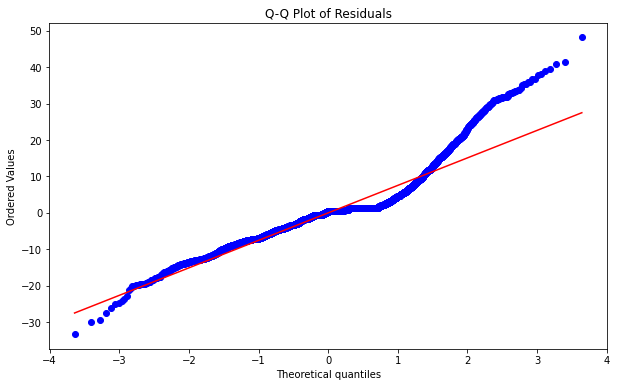

Shapiro-Wilk Test Statistic: 0.8922059535980225
Shapiro-Wilk p-value: 0.0


D:\pythonProject\general_python_codes\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
from scipy.stats import shapiro, probplot

import numpy as np
sample_residuals = model.resid

# Plotting the Q-Q plot
plt.figure(figsize=(10, 6))
probplot(sample_residuals, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Calculating the Shapiro-Wilk test statistic and p-value
shapiro_stat, shapiro_p_value = shapiro(sample_residuals)

print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}")
print(f"Shapiro-Wilk p-value: {shapiro_p_value}")

### Applying Transformations

In [26]:
def sm_model(X_train,y_train):
    X_train_tem = sm.add_constant(X_train)  
    model = sm.OLS(y_train, X_train_tem).fit()
    print(model.summary())

In [27]:
# Log transform

scaler= StandardScaler()
log_x = np.log(X + 1)
X_scaled= scaler.fit_transform(log_x)
X_train,X_test, y_train, y_test= train_test_split(X_scaled, y, shuffle=True, test_size=0.2)

sm_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     1319.
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:05:17   Log-Likelihood:                -18102.
No. Observations:                5117   AIC:                         3.621e+04
Df Residuals:                    5113   BIC:                         3.624e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8974      0.116     76.462      0.0

In [28]:
# Sqrt transform

scaler= StandardScaler()
sqrt_x = np.sqrt(X)
X_scaled= scaler.fit_transform(sqrt_x)
X_train,X_test, y_train, y_test= train_test_split(X_scaled, y, shuffle=True, test_size=0.2)

sm_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     1439.
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:05:17   Log-Likelihood:                -18071.
No. Observations:                5117   AIC:                         3.615e+04
Df Residuals:                    5113   BIC:                         3.618e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9273      0.116     77.176      0.0

In [29]:
# Z-score Standardization

scaler= StandardScaler()
z_x = (X - np.mean(X)) / np.std(X)
X_scaled= scaler.fit_transform(z_x)
X_train,X_test, y_train, y_test= train_test_split(X_scaled, y, shuffle=True, test_size=0.2)

sm_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1595.
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:05:17   Log-Likelihood:                -17908.
No. Observations:                5117   AIC:                         3.582e+04
Df Residuals:                    5113   BIC:                         3.585e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8675      0.112     79.155      0.0

---------------
None of the 3 transformations affected the normality of the input data

## Conclusion

The given data of user deposit, raking days and the total games played does not hold a linear relation with the rake generated, which is proved by low probabilities of Omnibus Test, Shapiro Wilk test, JB test and non-straight line in the QQ-plot of the residuals of the trained model

Linear Regression is not a good fit for this problem statement